# Rohin's Attempt lol - for the 3 cluster cases

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from numpy.random import multivariate_normal as mvn

from scipy.stats import norm
from scipy.optimize import minimize

from math import floor
from math import log

from KNN import KNN

from accuracy import GSSL_acc
from tqdm import tqdm

## Generate Points

Generate X values

In [14]:
m = 102 # Number of samples (MAKE THIS A MULTIPLE OF 3)

knownvals = [int(j*m/3) for j in range(3)] # Points for which we know the value of the label

centers = [[0,0],[1,0],[1,1]]
covar = 0.01*np.identity(2)

X = mvn(centers[0],covar, int(m/3))
X = np.append(X,mvn(centers[1],covar, int(m/3)), axis=0)
X = np.append(X,mvn(centers[2],covar, int(m/3)), axis=0)

Generate y values

In [15]:
y = [1 for i in range(int(m/3))]
y = y + [-1 for i in range(m - len(y))]

Plot points with labels

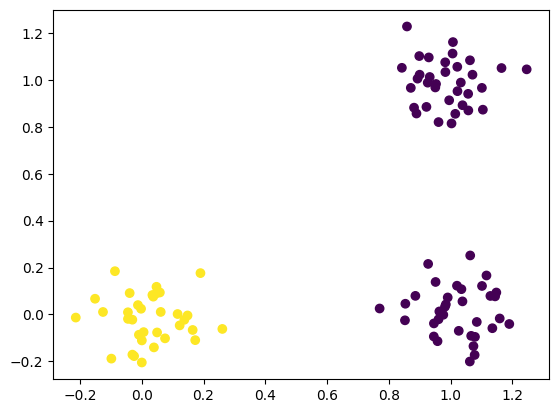

In [16]:
xs = X[:,0]
ys = X[:,1]

plt.scatter(xs, ys, c=y, cmap = "viridis")

## Build the Graph

In [17]:
k = 10
rbf = lambda x1, x2, gamma: np.exp(-gamma*np.linalg.norm(x1 - x2)**2)

L, W = KNN(X,k,m,rbf)

Making plot with edges

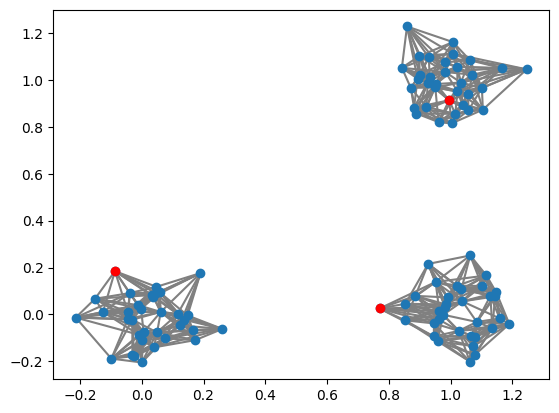

In [18]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys)
plt.scatter(xs_k, ys_k, color="red")

for i in range(m):
	for j in range(i,m):
		if W[i,j] > 0:
			plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color = "gray", zorder = 0)

## Form Optimization Problem

Define loss function

In [19]:
def probit(kvals, y, f):
	return -sum([log(norm.cdf(y[j]*f[j])) for j in kvals])

Define regularization

In [20]:
def regular(lamb,C_inv,f):
    f_T = np.array(f).T
    return lamb*f_T.dot(C_inv).dot(f)

In [21]:
tau = 1
alpha: int = 2
lamb = (tau**(2*alpha))/2
C = np.linalg.matrix_power(((L + (tau**2)*np.eye(m))),-alpha)
C_inv = np.linalg.inv(C)

Going to minimization

In [22]:
def to_minimize(f,kvals,y,lamb,C_inv):
    return probit(kvals,y,f) + regular(lamb,C_inv,f)

In [23]:
f0 = np.zeros(m)

result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv), method='BFGS')

In [24]:
f_star = result.x

y_pred = np.sign(f_star)

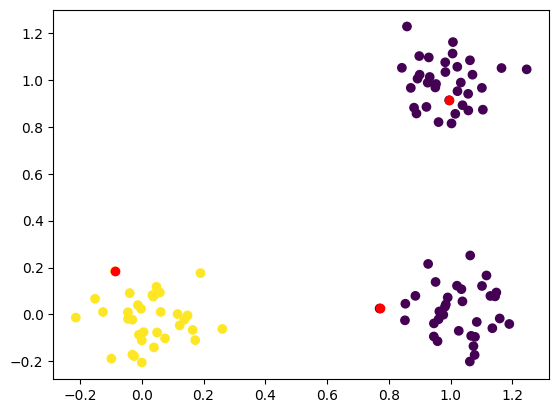

In [25]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

## Compute Accuracy

In [26]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/m
print(accuracy)

1.0


## Do it a bunch

In [29]:
accs = []

for i in tqdm(range(50)):
	m = 102 # Number of samples (MAKE THIS A MULTIPLE OF 3)

	knownvals = [int(j*m/3) for j in range(3)] # Points for which we know the value of the label

	centers = [[0,0],[1,0],[1,1]]
	covar = 0.01*np.identity(2)

	X = mvn(centers[0],covar, int(m/3))
	X = np.append(X,mvn(centers[1],covar, int(m/3)), axis=0)
	X = np.append(X,mvn(centers[2],covar, int(m/3)), axis=0)

	y = [1 for i in range(int(m/3))]
	y = y + [-1 for i in range(m - len(y))]

	accs += [GSSL_acc(X, y, knownvals, k = 10, alpha = 1, tau = 2, lossf = "probit")]

100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


In [31]:
print(sum(accs)/50)

1.0
